In [2]:
import os
import re
import shutil
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, Reshape

path = "./archive/"
data_path = "./data/"

In [3]:
# Generate the data file
if not os.path.exists(data_path):
    os.makedirs(data_path)

count = 0
for obj in os.listdir(path):
    sub_path = os.path.join(path, obj)
    if os.path.isdir(sub_path):
        for cate in os.listdir(sub_path):
            cate_path = os.path.join(sub_path, cate)
            for file in os.listdir(cate_path):
                shutil.move(os.path.join(cate_path, file), os.path.join(data_path, f"{count}.jpg"))
                count += 1
                
shutil.rmtree(path)
print(f"Data: {count} images.")

# Convert .jpg file to numpy array and resize the image
data_lst = os.listdir(data_path)
image_arr = list()
for fig in data_lst:
    image = cv2.imread(os.path.join(data_path, fig))
    image = cv2.resize(image, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    image_arr.append(np.asarray(image))
    os.remove(os.path.join(data_path, fig))
np.save(os.path.join(data_path, "part3.npy"), image_arr)

Data: 13639 images.


In [3]:
# Use modified load_real_samples and grid_plot functions in the tutorial
def load_real_samples(scale=False):
    X = np.load(os.path.join(data_path, "part3.npy"))
    if scale:
        X = (X - 127.5) * 2
    return X / 255.
                
    
def grid_plot(images, epoch="", name="", n=3, save=False, scale=False):
    if scale:
        images = (images + 1) / 2.0
    for index in range(n * n):
        plt.subplot(n, n, 1 + index)
        plt.axis('off')
        plt.imshow(images[index])
    fig = plt.gcf()
    fig.suptitle(name + '  '+ str(epoch), fontsize=14)
    if save:
        filename = 'results/generated_plot_e%03d_f.png' % (epoch+1)
        plt.savefig(filename)
        plt.close()
    plt.show()

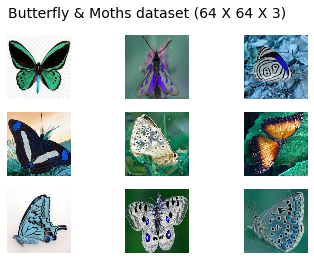

In [4]:
dataset = load_real_samples()
np.random.seed(42)
grid_plot(dataset[np.random.randint(0, 1000, 9)], name="Butterfly & Moths dataset (64 X 64 X 3)", n=3)

In [5]:
# Use build_conv_net and build_deconv_net functions in the tutorial
def build_conv_net(in_shape, out_shape, n_downsampling_layers=4, filters=128, out_activation='sigmoid'):
    """
    Build a basic convolutional network
    """
    model = tf.keras.Sequential()
    default_args=dict(kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')

    model.add(Conv2D(input_shape=in_shape, **default_args, filters=filters))

    for _ in range(n_downsampling_layers):
        model.add(Conv2D(**default_args, filters=filters))

    model.add(Flatten())
    model.add(Dense(out_shape, activation=out_activation) )
    model.summary()
    return model


def build_deconv_net(latent_dim, n_upsampling_layers=4, filters=128, activation_out='sigmoid'):
    """
    Build a deconvolutional network for decoding/upscaling latent vectors

    When building the deconvolutional architecture, usually it is best to use the same layer sizes that 
    were used in the downsampling network and the Conv2DTranspose layers are used instead of Conv2D layers. 
    Using identical layers and hyperparameters ensures that the dimensionality of our output matches the
    shape of our input images. 
    """
    model = tf.keras.Sequential()
    model.add(Dense(4 * 4 * 128, input_dim=latent_dim)) 
    model.add(Reshape((4, 4, 128))) # This matches the output size of the downsampling architecture
    default_args=dict(kernel_size=(3,3), strides=(2,2), padding='same', activation='relu')
    
    for i in range(n_upsampling_layers):
        model.add(Conv2DTranspose(**default_args, filters=filters))

    # This last convolutional layer converts back to 3 channel RGB image
    model.add(Conv2D(filters=3, kernel_size=(3,3), activation=activation_out, padding='same'))
    model.summary()
    return model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 128)         147584    
                                                                 
 conv2d_8 (Conv2D)           (None, 2, 2, 128)         147584    
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)              

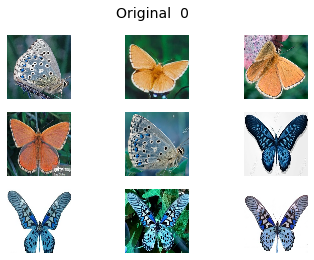

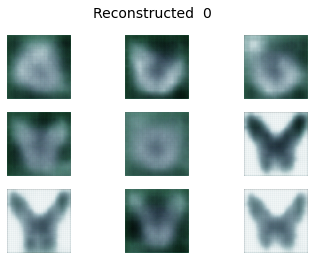


Epoch:  2


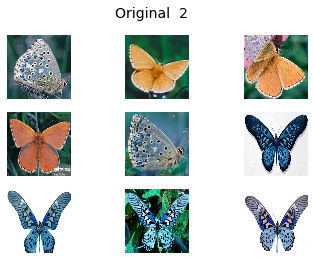

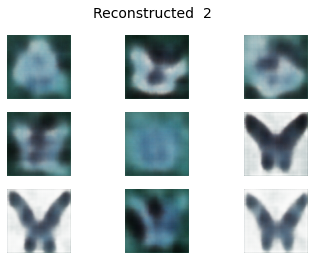


Epoch:  4


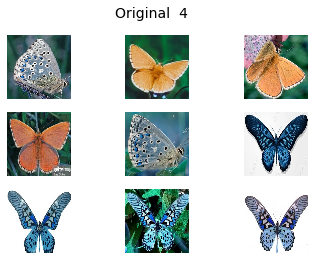

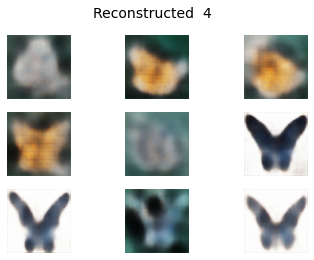


Epoch:  6


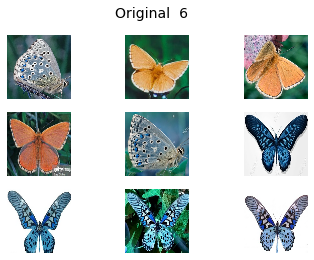

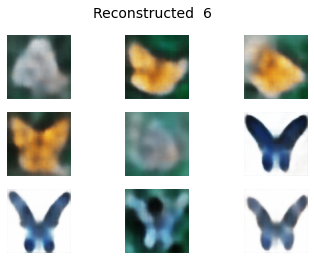


Epoch:  8


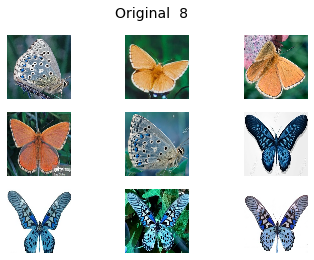

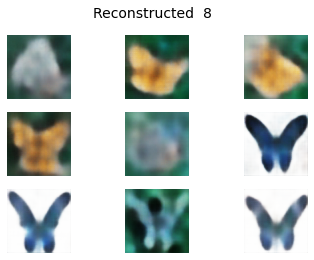


Epoch:  10


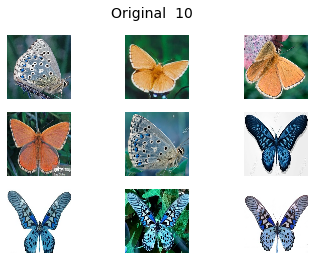

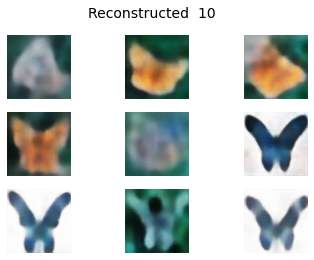

In [7]:
# CAE
# Use the build_convolutional_autoencoder function in the tutorial
def build_convolutional_autoencoder(data_shape, latent_dim, filters=128):
    encoder = build_conv_net(in_shape=data_shape, out_shape=latent_dim, filters=filters)
    decoder = build_deconv_net(latent_dim, activation_out='sigmoid', filters=filters)
    autoencoder = tf.keras.Sequential([encoder, decoder])
    autoencoder.compile(loss='binary_crossentropy', optimizer='adam')
    return autoencoder

# Defining the model dimensions and building it
image_size = dataset.shape[1:]
latent_dim = 512
num_filters = 128
cae = build_convolutional_autoencoder(image_size, latent_dim, num_filters)

for epoch in range(0, 11):
    cae.fit(x=dataset, y=dataset, epochs=1, batch_size=64, verbose=0)
    if epoch % 2 == 0:
        print('\nEpoch: ', epoch)
        samples = dataset[:9]
        reconstructed = cae.predict(samples, verbose=0)
        grid_plot(samples, epoch, name='Original', n=3, save=False)
        grid_plot(reconstructed, epoch, name='Reconstructed', n=3, save=False)

In [6]:
# Use the Sampling class and the build_vae function in the tutorial
class Sampling(tf.keras.layers.Layer):
    """
    Custom layer for the variational autoencoder
    It takes two vectors as input - one for means and other for variances of the latent variables described by a multimodal gaussian
    Its output is a latent vector randomly sampled from this distribution
    """
    def call(self, inputs):
        z_mean, z_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_var) * epsilon

    
def build_vae(data_shape, latent_dim, filters=128):

    # Building the encoder - starts with a simple downsampling convolutional network  
    encoder = build_conv_net(data_shape, latent_dim*2, filters=filters)
    
    # Adding special sampling layer that uses the reparametrization trick 
    z_mean = Dense(latent_dim)(encoder.output)
    z_var = Dense(latent_dim)(encoder.output)
    z = Sampling()([z_mean, z_var])
    
    # Connecting the two encoder parts
    encoder = tf.keras.Model(inputs=encoder.input, outputs=z)

    # Defining the decoder which is a regular upsampling deconvolutional network
    decoder = build_deconv_net(latent_dim, activation_out='sigmoid', filters=filters)
    vae = tf.keras.Model(inputs=encoder.input, outputs=decoder(z))
    
    # Adding the special loss term
    kl_loss = -0.5 * tf.reduce_sum(z_var - tf.square(z_mean) - tf.exp(z_var) + 1)
    vae.add_loss(kl_loss/tf.cast(tf.keras.backend.prod(data_shape), tf.float32))

    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy')

    return encoder, decoder, vae

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 conv2d_12 (Conv2D)          (None, 8, 8, 128)         147584    
                                                                 
 conv2d_13 (Conv2D)          (None, 4, 4, 128)         147584    
                                                                 
 conv2d_14 (Conv2D)          (None, 2, 2, 128)         147584    
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 64)               

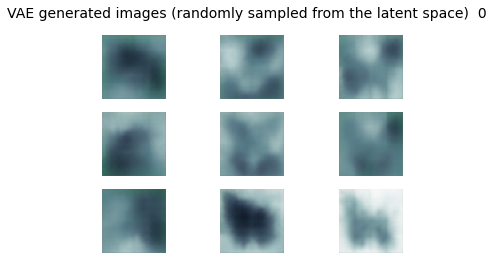

1705/1705 [==============================] - 21s 12ms/step - loss: 0.6088


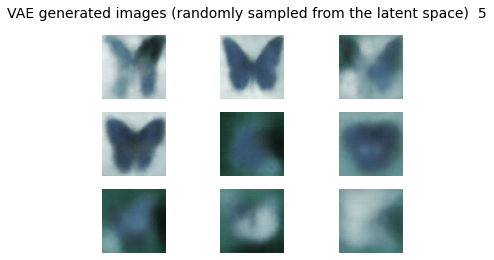

1705/1705 [==============================] - 22s 13ms/step - loss: 0.6038


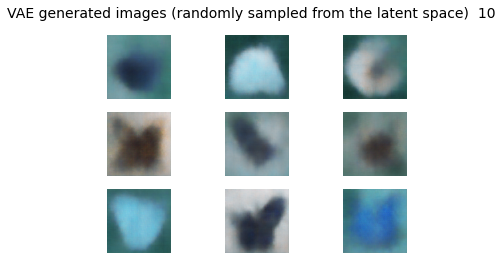

1705/1705 [==============================] - 22s 13ms/step - loss: 0.6022


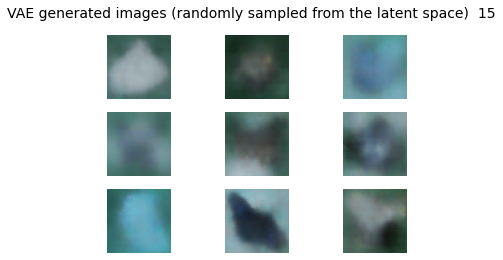

1705/1705 [==============================] - 21s 12ms/step - loss: 0.6009


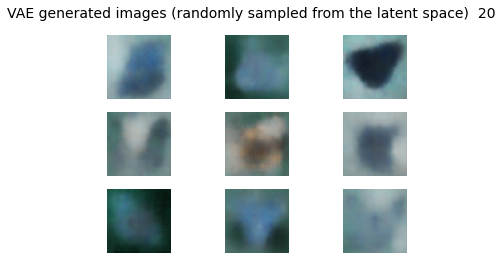

1705/1705 [==============================] - 22s 13ms/step - loss: 0.6000


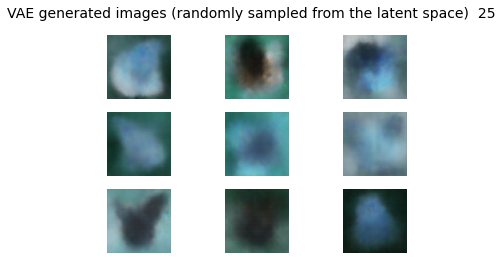

1705/1705 [==============================] - 21s 13ms/step - loss: 0.5993


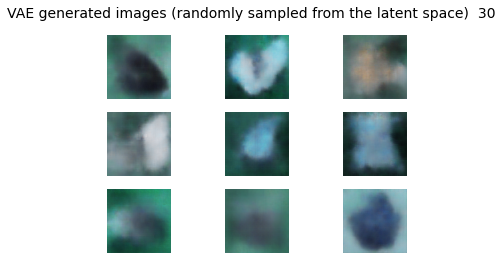

1705/1705 [==============================] - 20s 12ms/step - loss: 0.5989


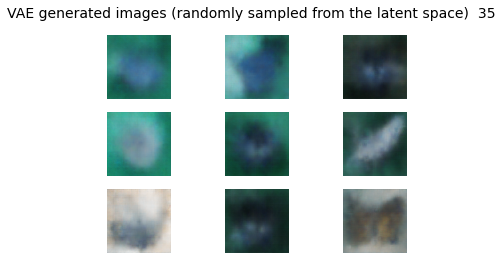

1705/1705 [==============================] - 20s 12ms/step - loss: 0.5985


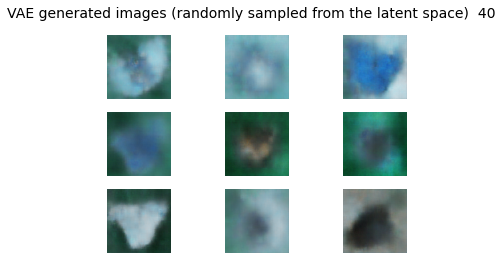

1705/1705 [==============================] - 21s 12ms/step - loss: 0.5980


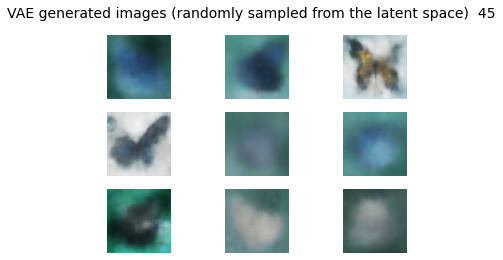

1705/1705 [==============================] - 23s 13ms/step - loss: 0.5977


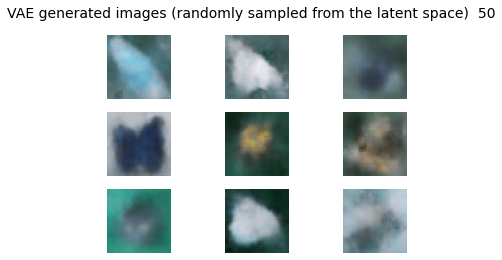

1705/1705 [==============================] - 22s 13ms/step - loss: 0.5974


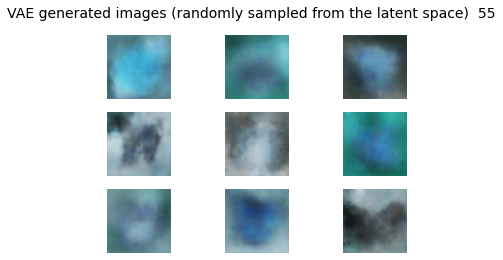

1705/1705 [==============================] - 21s 12ms/step - loss: 0.5971


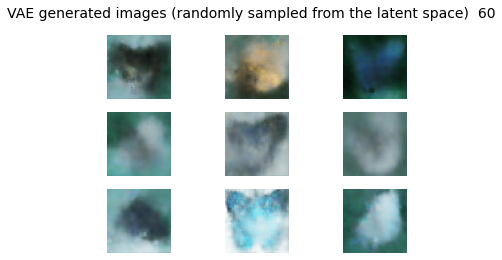

1705/1705 [==============================] - 22s 13ms/step - loss: 0.5969


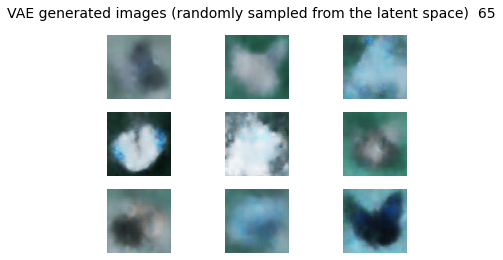

1705/1705 [==============================] - 22s 13ms/step - loss: 0.5967


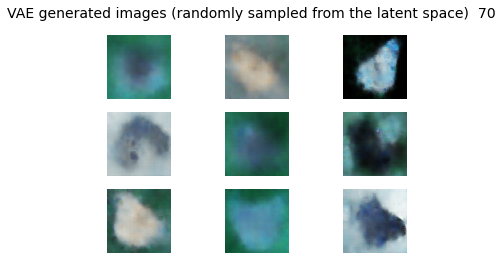

1705/1705 [==============================] - 21s 12ms/step - loss: 0.5965


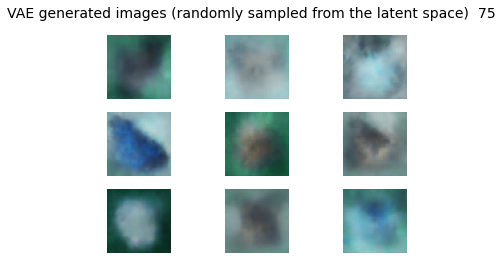

1705/1705 [==============================] - 20s 12ms/step - loss: 0.5962


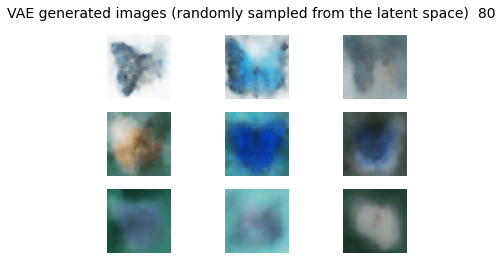

1705/1705 [==============================] - 22s 13ms/step - loss: 0.5961


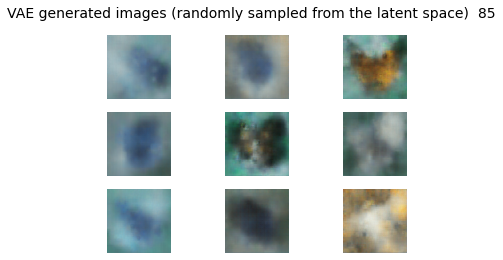

1705/1705 [==============================] - 21s 12ms/step - loss: 0.5960


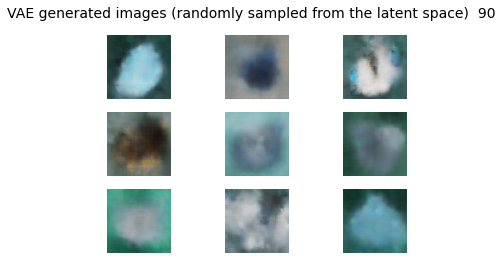

1705/1705 [==============================] - 22s 13ms/step - loss: 0.5959


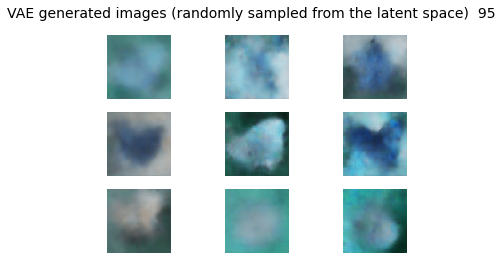

1705/1705 [==============================] - 23s 14ms/step - loss: 0.5957


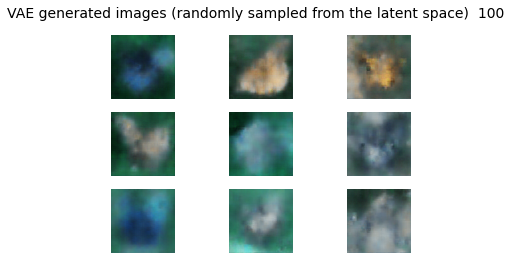

In [9]:
# Training the VAE model
latent_dim = 32
encoder, decoder, vae = build_vae(dataset.shape[1:], latent_dim, filters=128)

# Generate random vectors that we will use to sample our latent space
for epoch in range(0, 101):
    vae.fit(x=dataset, y=dataset, epochs=1, batch_size=8, verbose=1)
    if epoch % 5 == 0:
        decoder.save_weights(f'./vae-models/checkpoint{epoch}')
        latent_vectors = np.random.randn(9, latent_dim)
        images = decoder(latent_vectors)
        grid_plot(images, epoch, name='VAE generated images (randomly sampled from the latent space)', n=3, save=False)

In [96]:
latent_dim = 32
_encoder, vae_decoder, _vae = build_vae(dataset.shape[1:], latent_dim, filters=128)

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 conv2d_55 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 conv2d_56 (Conv2D)          (None, 8, 8, 128)         147584    
                                                                 
 conv2d_57 (Conv2D)          (None, 4, 4, 128)         147584    
                                                                 
 conv2d_58 (Conv2D)          (None, 2, 2, 128)         147584    
                                                                 
 flatten_9 (Flatten)         (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 64)              

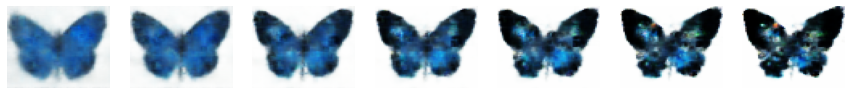

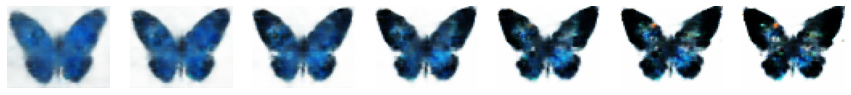

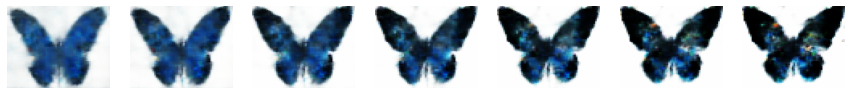

In [105]:
vae_decoder.load_weights('./vae-models/checkpoint100')

for i in range(-1, 5, 2):
    np.random.seed(227)
    latent_vectors = np.tile(np.random.randn(latent_dim), (7, 1))
    latent_vectors[:, 5] = np.linspace(1.5, 7.5, num=7)
    latent_vectors[:, 28] = i * np.ones(7)

    images = vae_decoder(latent_vectors)
    plt.figure(figsize = (15, 1.5))
    for index in range(7):
        plt.subplot(1, 7, index + 1)
        plt.axis('off')
        plt.imshow(images[index], aspect='auto')
    plt.show()

In [30]:
# Use build_gan, run_generator, get_batch, train_gan function in the tutorial
def build_gan(data_shape, latent_dim, filters=128, lr=0.0002, beta_1=0.5):
    optimizer = tf.optimizers.Adam(learning_rate=lr, beta_1=beta_1)

    # Usually the GAN generator has tanh activation function in the output layer
    generator = build_deconv_net(latent_dim, activation_out='tanh', filters=filters)
    
    # Build and compile the discriminator
    discriminator = build_conv_net(in_shape=data_shape, out_shape=1, filters=filters) # Single output for binary classification
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    # End-to-end GAN model for training the generator
    discriminator.trainable = False
    true_fake_prediction = discriminator(generator.output)
    GAN = tf.keras.Model(inputs=generator.input, outputs=true_fake_prediction)
    GAN = tf.keras.models.Sequential([generator, discriminator])
    GAN.compile(loss='binary_crossentropy', optimizer=optimizer)
    
    return discriminator, generator, GAN


def run_generator(generator, n_samples=100):
    """
    Run the generator model and generate n samples of synthetic images using random latent vectors
    """
    latent_dim = generator.layers[0].input_shape[-1]
    generator_input = np.random.randn(n_samples, latent_dim)

    return generator.predict(generator_input)
    

def get_batch(generator, dataset, batch_size=64):
    """
    Gets a single batch of samples (X) and labels (y) for the training the discriminator.
    One half from the real dataset (labeled as 1s), the other created by the generator model (labeled as 0s).
    """
    batch_size //= 2 # Split evenly among fake and real samples

    fake_data = run_generator(generator, n_samples=batch_size)
    real_data = dataset[np.random.randint(0, dataset.shape[0], batch_size)]

    X = np.concatenate([fake_data, real_data], axis=0)
    y = np.concatenate([np.zeros([batch_size, 1]), np.ones([batch_size, 1])], axis=0)

    return X, y


def train_gan(generator, discriminator, gan, dataset, latent_dim, n_epochs=20, batch_size=64):

    batches_per_epoch = int(dataset.shape[0] / batch_size / 2)
    for epoch in range(n_epochs):
        for batch in range(batches_per_epoch):
            
            # 1) Train discriminator both on real and synthesized images
            X, y = get_batch(generator, dataset, batch_size=batch_size)
            discriminator_loss = discriminator.train_on_batch(X, y)

            # 2) Train generator (note that now the label of synthetic images is reversed to 1)
            X_gan = np.random.randn(batch_size, latent_dim)
            y_gan = np.ones([batch_size, 1])
            generator_loss = gan.train_on_batch(X_gan, y_gan)
            
        if epoch % 5 == 0:
            generator.save_weights(f'./gan-models/checkpoint{epoch + 251}')
            noise = np.random.randn(16, latent_dim)
            images = generator.predict(noise)
            grid_plot(images, epoch + 251, name='GAN generated images', n=3, save=False, scale=True)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 2048)              526336    
                                                                 
 reshape_7 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_28 (Conv2D  (None, 8, 8, 128)        147584    
 Transpose)                                                      
                                                                 
 conv2d_transpose_29 (Conv2D  (None, 16, 16, 128)      147584    
 Transpose)                                                      
                                                                 
 conv2d_transpose_30 (Conv2D  (None, 32, 32, 128)      147584    
 Transpose)                                                      
                                                     

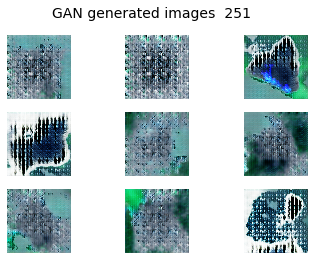

In [31]:
# Build and train the model (need around 10 epochs to start seeing some results)
latent_dim = 256
discriminator, generator, gan = build_gan(dataset.shape[1:], latent_dim, filters=128)
dataset_scaled = load_real_samples(scale=True)
generator.load_weights('./gan-models/checkpoint250')

train_gan(generator, discriminator, gan, dataset_scaled, latent_dim, n_epochs=100)

In [32]:
_discriminator, gan_generator, _gan = build_gan(dataset.shape[1:], latent_dim, filters=128)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 2048)              526336    
                                                                 
 reshape_8 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_32 (Conv2D  (None, 8, 8, 128)        147584    
 Transpose)                                                      
                                                                 
 conv2d_transpose_33 (Conv2D  (None, 16, 16, 128)      147584    
 Transpose)                                                      
                                                                 
 conv2d_transpose_34 (Conv2D  (None, 32, 32, 128)      147584    
 Transpose)                                                      
                                                     

1/1 [==============================] - 0s 37ms/step


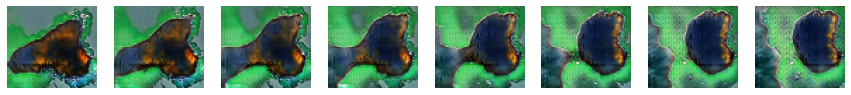

In [112]:
gan_generator.load_weights('./gan-models/checkpoint250')
latent_dim = 256

#1325-250, 39:0-16-14
np.random.seed(1325)
latent_vectors = np.tile(np.random.randn(latent_dim), (8, 1))
latent_vectors[:, 39] = np.linspace(0.0, 16.0, num=8)

images = gan_generator.predict(latent_vectors)
images = 0.5 * images + 0.5
plt.figure(figsize = (15, 1.5))
for index in range(8):
    plt.subplot(1, 8, index + 1)
    plt.axis('off')
    plt.imshow(images[index], aspect='auto')
plt.show()